In [1]:
import pandas as pd
import os
from visualization import *

In [2]:
dataset = "qsip_pc2_all"
print("subset columns:")
for file in os.listdir(f"results/{dataset}"):
    if file.endswith('.csv'):
        print(file[:-4])

subset columns:
cat2
copies_16s
cat3
treatment
experiment
cat1
details
site
isotope
kingdom
replicate
time


In [3]:
subset_col = "experiment"

In [4]:
results_df = pd.read_csv(f"results/{dataset}/{subset_col}.csv")

In [5]:
print("subset values:", set(results_df['subset']))

subset values: {'sro', 'win', 'dim', 'eag', 'ant', 'qme', 'drp'}


In [6]:
print("models: ", set(results_df['model']))

models:  {'featureless', 'linear', 'tree'}


{'dim': <Figure size 1600x500 with 12 Axes>,
 'drp': <Figure size 1600x500 with 12 Axes>,
 'eag': <Figure size 1600x500 with 12 Axes>,
 'ant': <Figure size 1600x500 with 12 Axes>,
 'qme': <Figure size 1600x500 with 12 Axes>,
 'sro': <Figure size 1600x500 with 12 Axes>,
 'win': <Figure size 1600x500 with 12 Axes>}

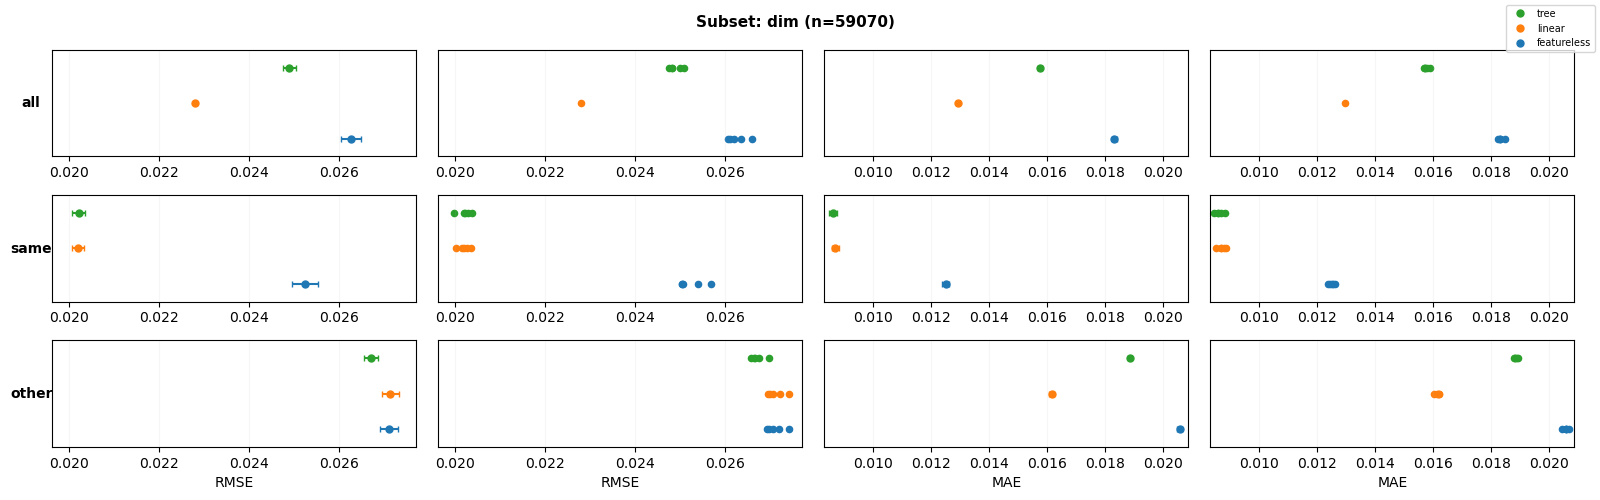

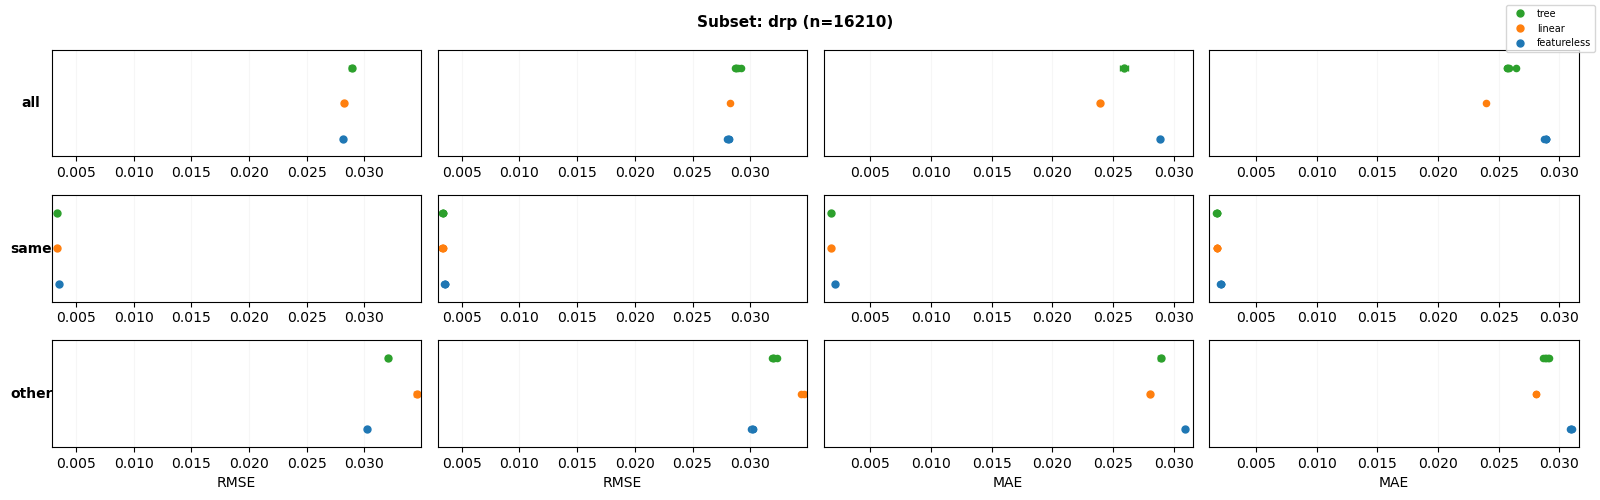

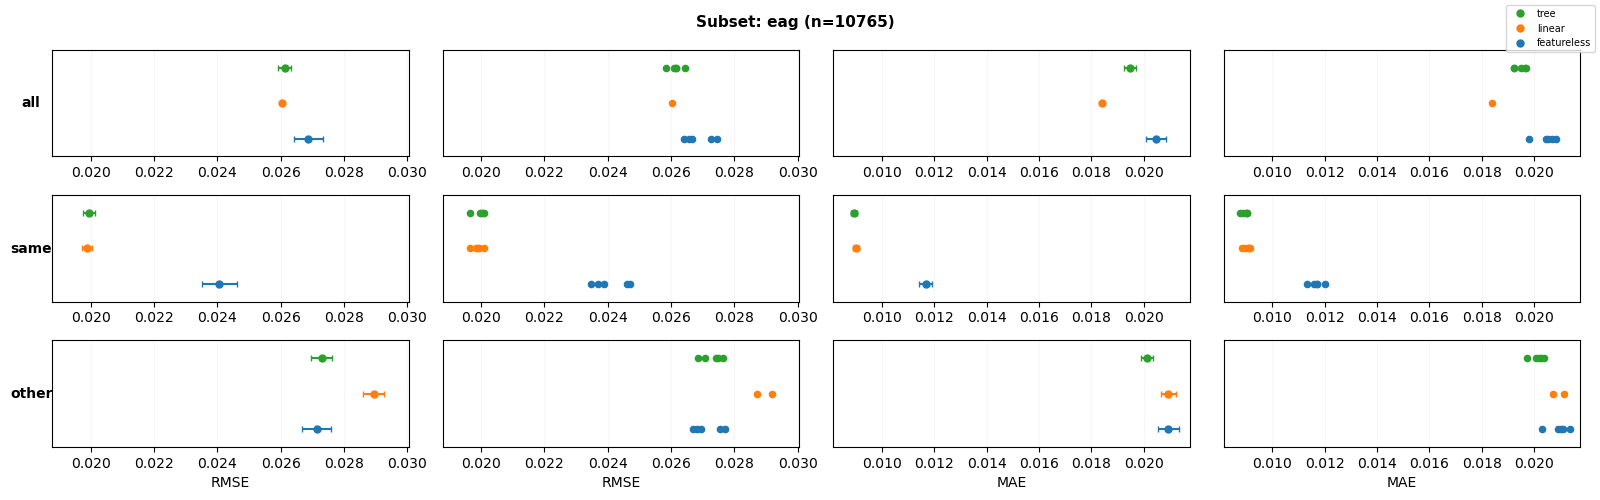

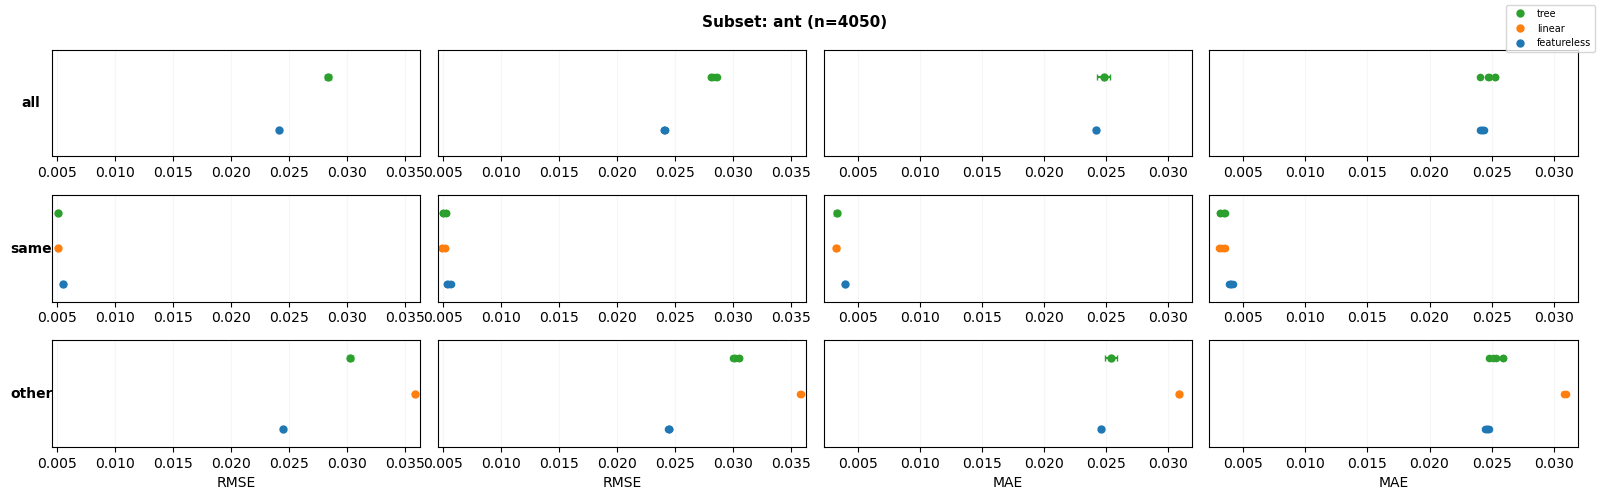

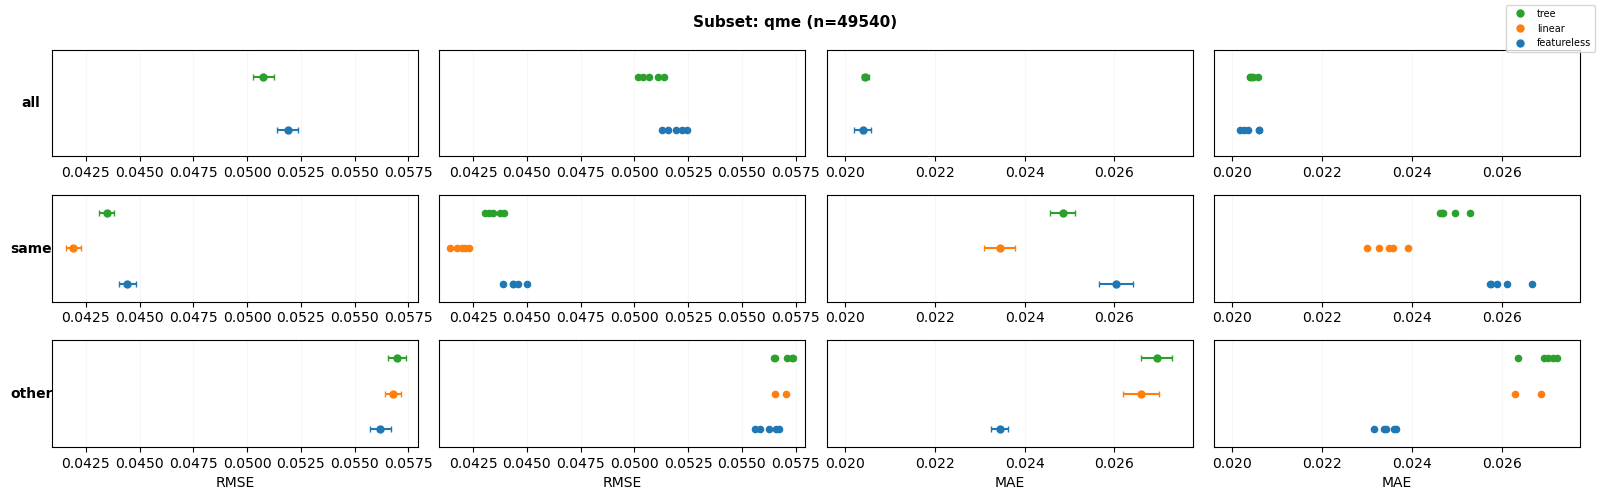

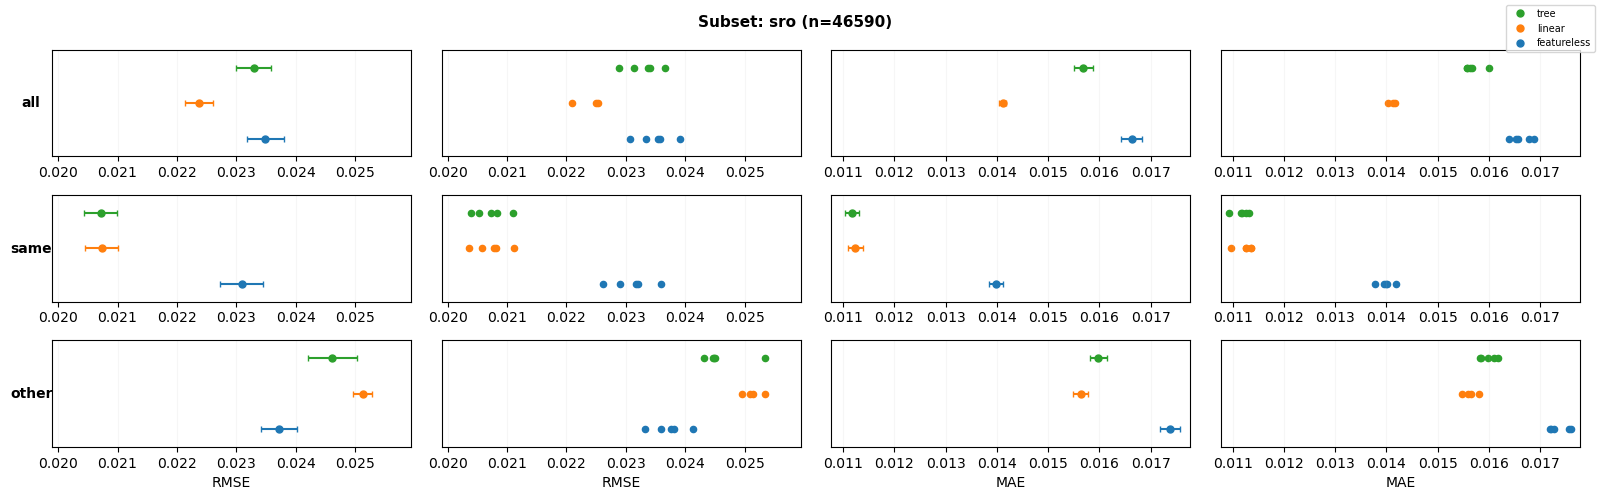

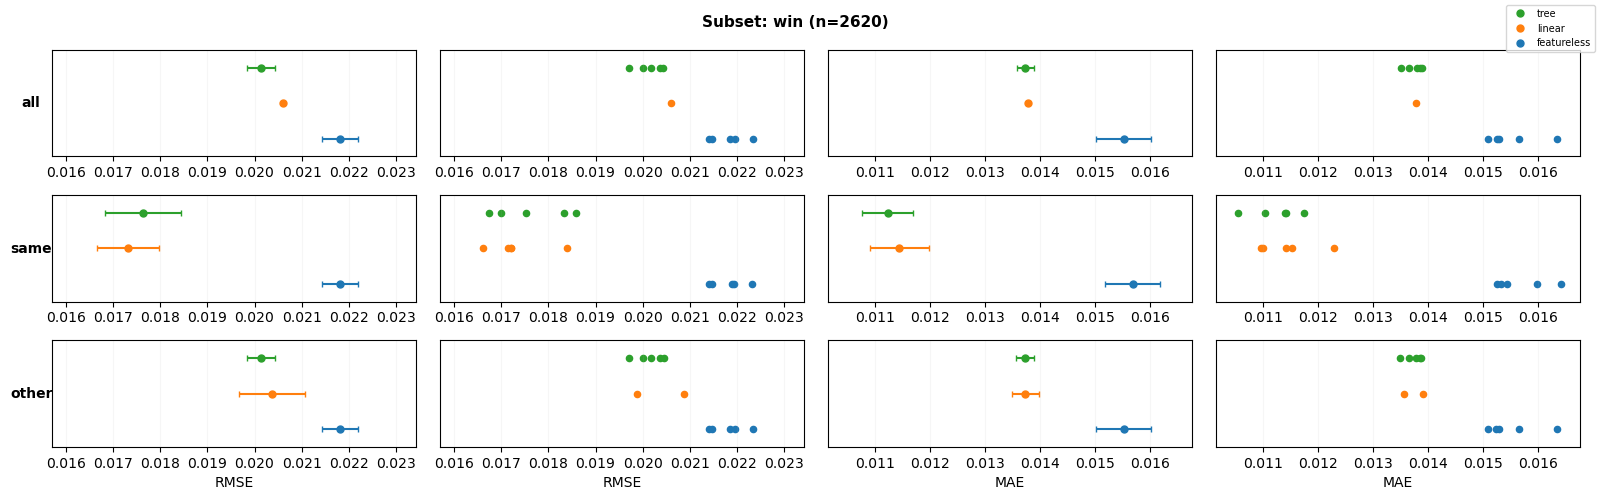

In [7]:
soak_plot_multiple_models(results_df)

In [8]:
# soak_plot_one_model(results_df, "Rhizo", "tree", "rmse", (6, 3))